<a href="https://colab.research.google.com/github/osgeokr/torchgeo-explained/blob/main/TorchGeo_%EA%B0%9D%EC%B2%B4_%ED%83%90%EC%A7%80_%EC%98%88%EC%A0%9C_%EC%86%8C%EA%B0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TorchGeo: 객체 탐지(object detection) 예제 소개

[TorchGeo](https://torchgeo.readthedocs.io/en/stable/)는 torchvision과 유사한 PyTorch 도메인 라이브러리로, 지리공간 데이터에 특화된 데이터셋, 샘플러, 변환, 그리고 사전 훈련된 모델을 제공합니다. 이번 실습은 TorchGeo에서 객체 탐지(object detection) 예제를 소개해 보겠습니다.

[VHR-10](https://torchgeo.readthedocs.io/en/stable/api/datasets.html#vhr-10)은 중국 서북공업대학교(NWPU: Northwestern Polytechnical University)에서 제공하는 초고해상도(Very High Resolution) 10개 클래스 원격탐사 이미지 데이터셋입니다.

총 800장의 초고해상도(VHR) 광학 원격탐사 이미지로 구성되어 있으며, 이 중 715장의 컬러 이미지는 Google Earth로부터 0.5에서 2m 사이의 공간 해상도로 획득되었고, 나머지 85장의 팬 샤프닝된 컬러 적외선(CIR: Color InfraRed) 이미지는 [Vaihingen(바이힝겐)](https://www.isprs.org/education/benchmarks/UrbanSemLab/2d-sem-label-vaihingen.aspx) 데이터로부터 0.08m 공간해상도로 획득되었습니다.

  > Note: [팬 샤프닝(pan-sharpening)](https://earthobservatory.nasa.gov/blogs/earthmatters/2017/06/13/how-to-pan-sharpen-landsat-imagery/)은 팬크로매틱 밴드의 고해상도의 디테일과 다른 밴드의 저해상도 색상 정보를 결합하는 기술입니다.

데이터셋은 두 세트로 나뉩니다:
- Positive image set(양성 이미지 세트: 650장): 이미지 내에 적어도 하나의 대상이 포함되어 있는 이미지
- Negative image set(음성 이미지 세트: 150장): 어떤 대상도 포함하지 않은 이미지

양성 이미지 세트는 다음과 같은 열 클래스의 객체를 포함합니다:
- Airplanes(비행기) (757)
- Ships(배) (302)
- Storage tanks(저장 탱크) (655)
- Baseball diamonds(야구장) (390)
- Tennis courts(테니스 코트) (524)
- Basketball courts(농구장) (159)
- Ground track fields(육상 트랙 필드) (163)
- Harbors(항구) (224)
- Bridges(다리) (124)
- Vehicles(차량) (477)

이는 객체 탐지 바운딩 박스(object detection bounding boxes)와 인스턴스 분할 마스크(instance segmentation masks)를 포함합니다.
  > Note: [인스턴스 분할(instance segmentation)](https://www.ibm.com/topics/instance-segmentation)은 이미지 내의 각 개별 객체 인스턴스의 정확한 픽셀별 경계를 예측하는 딥러닝 기반 컴퓨터 비전 작업입니다. 이미지 분할의 더 큰 분야의 일부인 인스턴스 분할은 기존 객체 탐지 알고리즘보다 더 자세하고 정교한 출력을 제공합니다. 다른 이미지 분할 작업에는 각 픽셀을 그것이 대표하는 '사물' 또는 '배경요소'의 의미적 분류로 분류하는 의미적 분할(semantic segmentation)과, 인스턴스 분할 및 의미적 분할의 목표를 모두 결합하는 파노픽 분할(panoptic segmentation)이 포함됩니다. 인스턴스 분할은 의료 이미지 분석부터 위성 이미지에서 관심 객체 탐지, 자율 주행 차량의 탐색 활성화에 이르기까지 다양한 산업에서 다양한 이미지 처리 사용 사례를 가지고 있습니다.

이 데이터셋을 연구에 사용하는 경우, 다음 논문들을 인용해야 합니다:
- https://doi.org/10.1016/j.isprsjprs.2014.10.002
- https://doi.org/10.1109/IGARSS.2019.8898573
- https://doi.org/10.3390/rs12060989

TorchGeo 문서는 이 데이터셋을 사용하기 위한 추가 라이브러리를 다음과 같이 안내하고 있습니다:

- 데이터셋이 RAR 파일로 저장되어 있으므로, 이를 추출하기 위한 [rarfile](https://pypi.org/project/rarfile/)
- "양성" 이미지 세트에 대한 annotations.json 파일을 불러오기 위한 [pycocotools](https://pypi.org/project/pycocotools/)
  > Note: pycocotools는 원본 [cocoapi](https://github.com/cocodataset/cocoapi)의 포크입니다. [COCO](http://cocodataset.org/)는 객체 감지, 분할, 사람 키포인트 감지, 배경요소 분할, 그리고 캡션 생성을 위해 설계된 대규모 이미지 데이터셋입니다.

학습에 앞서 노트북 상단 메뉴에서 런타임 > 런타임 유형 변경을 선택합니다. 하드웨어 가속기 메뉴에서 GPU를 선택하고 저장합니다.
  > NVIDIA T4 GPU는 NVIDIA의 Tesla 시리즈 중 하나로, 데이터 센터와 클라우드 환경을 위해 설계된 GPU입니다. T4는 특히 인공지능(AI) 추론, 머신러닝(ML), 그리고 딥러닝 워크로드에 최적화되어 있으며, NVIDIA Turing 아키텍처를 기반으로 합니다. 이 GPU는 고성능 컴퓨팅(HPC), 데이터 분석, 그래픽스 작업에도 사용됩니다.
  
  > NVIDIA Turing 아키텍처에서 Turing은 앨런 튜링(Alan Turing)의 이름을 따서 명명되었습니다. 앨런 튜링은 영국의 수학자, 논리학자, 암호학자이며 컴퓨터 과학의 아버지로 불립니다. 특히, 튜링 기계 개념을 통해 현대 컴퓨터 과학의 이론적 기반을 마련했습니다.

## VHR-10 데이터셋 다운로드를 위한 기본 코드

TorchGeo는 `pip install torchgeo`를 비교적 가볍게 만들기 위해 필수 의존성 세트만 설치하고 있습니다. 선택적 의존성 세트를 포함한 전체 설치는 `pip install torchgeo[datasets]`를 사용하시면 됩니다. 후자로 설치한다면 VHR-10 데이터셋 사용을 위한 `rarfile`과 `pycocotools`는 자동 설치됩니다.

- `pip install torchgeo`: "필수(Required)" 의존성 세트 설치
- `pip install torchgeo[datasets]`:  "선택적(Optional)" 의존성 세트를 포함한 전체 설치

In [1]:
%pip install -q -U torchgeo[datasets]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.1/381.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 741.0/741.0 kB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

[PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/)을 설치합니다. PyTorch Lightning은 PyTorch의 상위 레벨 인터페이스를 제공하여, 모델 학습 과정을 더 간결하고 효율적으로 만들어 줍니다.

In [2]:
!pip install -q -U pytorch-lightning

필요한 라이브러리를 임포트하고, TorchGeo의 버전을 확인합니다.

In [3]:
import torchgeo
from torchgeo.datasets import VHR10
import matplotlib.pyplot as plt

In [4]:
import os, gdown

os.makedirs('data/VHR10/', exist_ok=True)

url = 'https://drive.google.com/uc?id=1--foZ3dV5OCsqXQXT84UeKtrAqc5CkAE'
output_path = 'data/VHR10/NWPU VHR-10 dataset.rar'
gdown.download(url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1--foZ3dV5OCsqXQXT84UeKtrAqc5CkAE
From (redirected): https://drive.google.com/uc?id=1--foZ3dV5OCsqXQXT84UeKtrAqc5CkAE&confirm=t&uuid=0d3d548b-de70-487f-8398-2109eeb71eb2
To: /content/data/VHR10/NWPU VHR-10 dataset.rar
100%|██████████| 76.8M/76.8M [00:03<00:00, 23.5MB/s]


'data/VHR10/NWPU VHR-10 dataset.rar'

아래 코드는 `VHR10` 데이터셋을 `data/VHR10/` 위치에서 'positive' 분할로 다운로드하고, 주어진 전처리 함수를 이용하여 변환을 적용합니다. `preprocess` 함수의 역할은 각 이미지를 부동소수점 타입으로 변환하고, 0과 1 사이의 값으로 정규화하기 위해 255로 나누는 것입니다. 이 과정은 모델 학습에 적합한 데이터 형태로 가공하는 데 도움을 줍니다.

In [5]:
def preprocess(sample):
    sample["image"] = sample["image"].float() / 255.0
    return sample

ds = VHR10(
    root="data/VHR10/",
    split="positive",
    transforms=preprocess,
    download=True,
    checksum=True,
)

Using downloaded and verified file: data/VHR10/NWPU VHR-10 dataset.rar
Extracting data/VHR10/NWPU VHR-10 dataset.rar to data/VHR10/


100%|██████████| 1265416/1265416 [00:00<00:00, 213660456.12it/s]

loading annotations into memory...


Done (t=0.03s)
creating index...
index created!


## VHR-10 데이터셋 열어보기

이제 양성 이미지 세트를 확인해 봅니다. 이미지는 총 650장입니다.

In [6]:
print(f"VHR-10 dataset: {len(ds)}")

VHR-10 dataset: 650


`ds` 데이터셋의 첫번째 항목에 접근하여 `"image"` 키에 해당하는 이미지의 차원을 확인해 봅니다. `shape` 속성은 해당 이미지의 차원을 반환하는데 (채널 수, 높이, 너비) 형태로 표현됩니다.

In [7]:
ds[0]["image"].shape

torch.Size([3, 808, 958])

임의로 여섯번째 항목의 이미지를 열어보겠습니다. 이미지의 차원을 (채널 수, 높이, 너비)에서 (높이, 너비, 채널 수)로 변경한 후 표시해 보겠습니다.

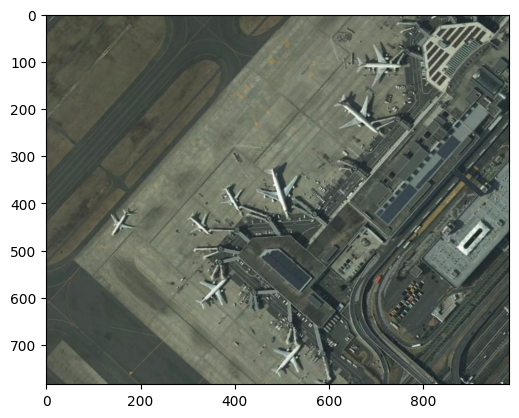

In [8]:
image = ds[5]["image"].permute(1, 2, 0)
plt.imshow(image)
plt.show()

TorchGeo의 VHR10 데이터셋에는 `annotations.json`에 포함된 주석을 시각화하는 `plot` 메서드가 있습니다. 이 주석들은 객체 탐지와 인스턴스 분할을 위한 정보를 제공하며, 바운딩 박스와 마스크 같은 시각적 요소들을 포함할 수 있습니다. 이를 통해 지상 실측값(ground truth)이 표기된 이미지를 직접 시각화하고 확인할 수 있습니다.

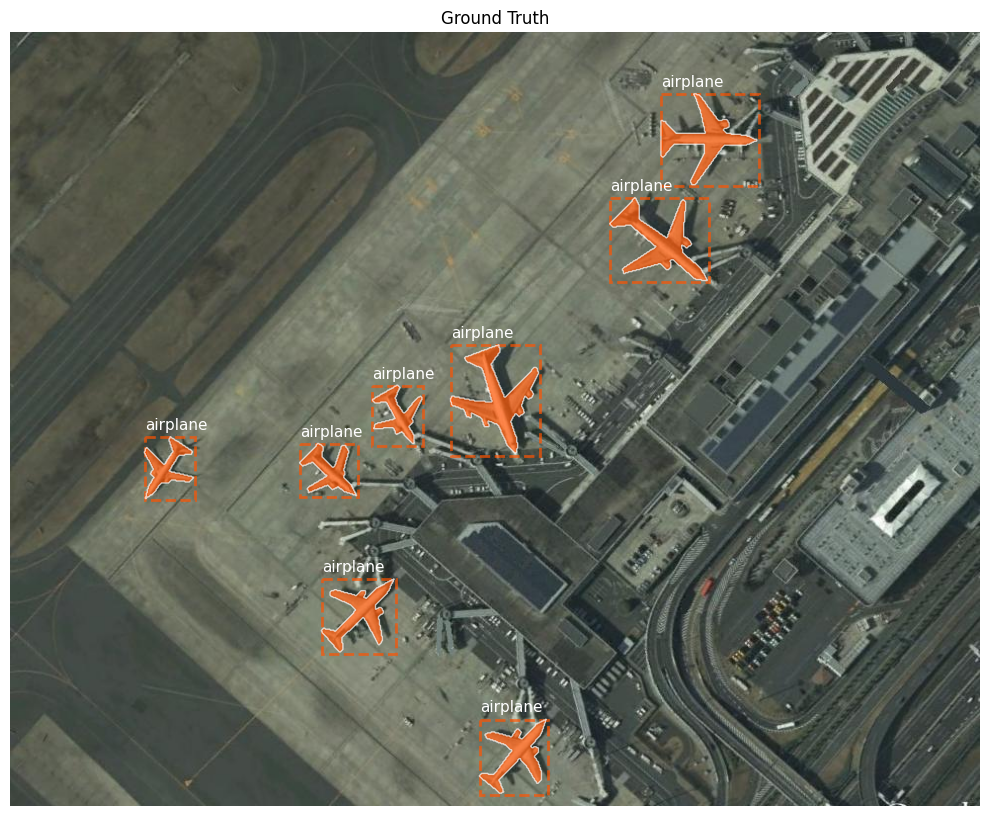

In [9]:
ds.plot(ds[5])
plt.savefig('ground_truth.png', bbox_inches='tight')
plt.show()

이제 Microsoft AI for Good의 케일럽 로빈슨(Caleb Robinson) 님이 제공하는 [torchgeo_object_detection_example.ipynb](https://gist.github.com/calebrob6/d32673997661a75d1a5e2e5c0afbe68a)를 통해, TorchGeo에서의 객체 탐지 훈련에 대한 예시를 경험해볼 수 있습니다.

아래는 PyTorch의 데이터 로더(DataLoader)를 사용하여 collate_fn 함수를 정의하고 이를 사용하여 데이터를 로드하는 과정을 보여줍니다.
  > collate_fn 함수는 주어진 배치에서 각 항목의 image, boxes, labels, masks를 추출하여 새로운 배치 딕셔너리를 구성합니다. 이렇게 구성된 새로운 배치는 모델 학습이나 평가에 직접 사용됩니다. DataLoader는 이 함수를 사용하여 데이터를 배치 단위로 모델에 공급할 준비를 합니다. shuffle=True 옵션은 모델 학습 시 데이터의 순서에 대한 의존성을 줄이기 위해 데이터셋의 순서를 무작위로 섞습니다.

In [10]:
import torch
from torch.utils.data import DataLoader

def collate_fn(batch):
    new_batch = {
        "image": [item["image"] for item in batch],  # 이미지
        "boxes": [item["boxes"] for item in batch],  # 바운딩 박스
        "labels": [item["labels"] for item in batch],  # 레이블
        "masks": [item["masks"] for item in batch],  # 마스크
    }
    return new_batch  # 새 배치 반환


# 데이터 로더

dl = DataLoader(
    ds,  # 데이터셋
    batch_size=32,  # 한 번에 로드할 데이터 수
    num_workers=2,  # 데이터 로딩을 위해 사용할 프로세스 수
    shuffle=True,  # 데이터를 로드하기 전에 데이터셋을 섞을지 여부
    collate_fn=collate_fn,  # 배치 처리를 위한 collate_fn 함수
)

이 코드는 객체 탐지(Object Detection) 작업을 위한 학습 클래스를 정의하고 인스턴스를 생성하는 과정을 보여줍니다. 특히, 이 클래스는 가변 크기의 입력을 처리할 수 있도록 설계되었습니다.

  > VariableSizeInputObjectDetectionTask 클래스는 표준 객체 탐지 작업(ObjectDetectionTask)을 상속받아, 각 배치 내에서 가변 크기의 입력 이미지를 처리할 수 있도록 training_step 메서드를 정의합니다. 이를 통해 모델이 다양한 크기의 입력 이미지에 대해 효과적으로 학습할 수 있습니다. 생성된 인스턴스는 Faster R-CNN 모델을 사용하여 지정된 설정으로 객체 탐지 작업을 수행할 준비를 합니다.

In [11]:
from torchgeo.trainers import ObjectDetectionTask

class VariableSizeInputObjectDetectionTask(ObjectDetectionTask):
    # 학습 단계 정의
    def training_step(self, batch, batch_idx, dataloader_idx=0):
        x = batch["image"]  # 이미지
        batch_size = len(x)  # 배치 크기 설정 (이미지 수)
        y = [
            {"boxes": batch["boxes"][i], "labels": batch["labels"][i]}
            for i in range(batch_size)
        ] # 각 이미지의 바운딩 박스와 레이블 정보 추출
        loss_dict = self(x, y)  # 손실
        train_loss: Tensor = sum(loss_dict.values())  # 학습 손실 (손실 값의 합)
        self.log_dict(loss_dict)  # 손실 값 기록
        return train_loss  # 학습 손실 반환

task = VariableSizeInputObjectDetectionTask(
    model="faster-rcnn",  # Faster R-CNN 모델
    backbone="resnet18",  # ResNet18 신경망 아키텍처
    weights=True,  # 사전 훈련된 가중치 사용
    in_channels=3,  # 입력 이미지의 채널 수 (RGB 이미지)
    num_classes=11,  # 분류할 클래스의 수
    trainable_layers=3,  # 훈련 가능한 층의 수
    lr=1e-3,  # 학습률
    patience=10,  # 학습 중 조기 종료를 위한 대기 횟수 설정
    freeze_backbone=False,  # 백본 네트워크의 가중치를 고정하지 않고 훈련할지 여부
)
task.monitor = "loss_classifier"  # 모니터링할 메트릭 설정 (여기서는 분류기의 손실)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


PyTorch Lightning 라이브러리를 사용하여 모델 학습을 위한 설정을 준비합니다. 아래 설정에서는 GPU를 사용하여 모델을 학습하고, 학습 로그와 체크포인트를 'logs/' 디렉토리에 저장하며, 최소 6 에포크에서 최대 100 에포크까지의 학습을 설정하고 있습니다.

In [12]:
import lightning.pytorch as pl

trainer = pl.Trainer(
    default_root_dir="logs/",  # 기본 디렉토리 설정
    accelerator="gpu",  # 학습에 사용할 하드웨어 가속기 종류 설정 (GPU 사용)
    devices=[0],  # 사용할 디바이스의 ID 목록 ([0]은 첫 번째 GPU 의미)
    min_epochs=6,  # 최소 학습 에포크 수 설정
    max_epochs=100,  # 최대 학습 에포크 수 설정
    log_every_n_steps=20,  # 몇 번의 스텝마다 로그를 기록할지 설정
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [13]:
%%time
# 모델 학습
trainer.fit(task, train_dataloaders=dl)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
I

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## 추론(inference) 예제

데이터 로더(dl)에서 다음 배치를 가져옵니다.

In [14]:
batch = next(iter(dl))

작업(task)에서 모델을 가져와 평가 모드로 설정합니다. 이렇게 하면 훈련 중에 사용되는 드롭아웃과 같은 특정 레이어가 비활성화됩니다.

`torch.no_grad()`는 기울기 계산을 비활성화하여 메모리 사용량을 줄이고 계산 속도를 높입니다. 이는 평가나 추론 과정에서 모델을 업데이트하지 않을 때 사용합니다. 이제 모델에 이미지 배치를 전달하여 예측 결과를 얻습니다.

In [15]:
model = task.model
model.eval()

with torch.no_grad():
  out = model(batch["image"])

특정 배치 인덱스(여기서는 0)에 대한 샘플을 정의합니다.

In [16]:
batch_idx = 0
sample = {
    "image": batch["image"][batch_idx],  # 이미지
    "boxes": batch["boxes"][batch_idx],  # 실제 경계 상자
    "labels": batch["labels"][batch_idx],  # 실제 라벨
    "masks": batch["masks"][batch_idx],  # 실제 마스크
    "prediction_labels": out[batch_idx]["labels"],  # 모델이 예측한 라벨
    "prediction_boxes": out[batch_idx]["boxes"],  # 모델이 예측한 경계 상자
    "prediction_scores": out[batch_idx]["scores"],  # 각 예측의 신뢰도 점수
}

이제 주어진 sample을 시각화합니다. plot 메서드는 sample에 포함된 이미지, 실제 레이블 및 경계 상자, 예측된 레이블 및 경계 상자 등을 시각화합니다.

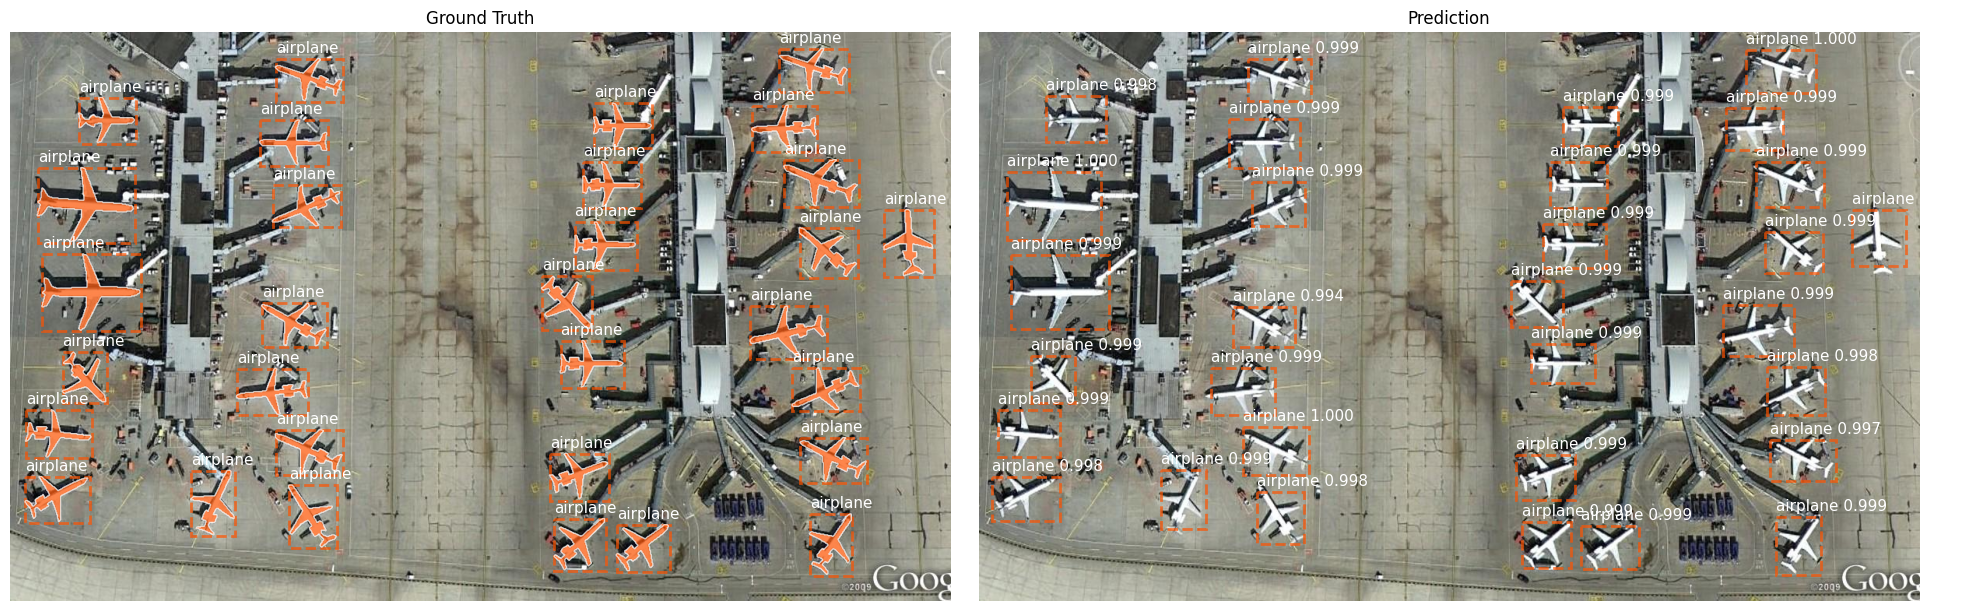

In [17]:
ds.plot(sample)
plt.savefig('inference.png', bbox_inches='tight')
plt.show()